In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import sys
import os

sys.path.append(os.path.expanduser('~/Documents/Apziva_projects'))
import feature_plots as fp

##Data Exploration

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

In [3]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'term-deposit-marketing-2020.csv'

In [ ]:
df.age.min()

19

In [ ]:
#sampling
#resamople to balance classes
#only on the train set
#probict_proba
df.y.value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

In [ ]:
2792/40000

0.0698

## Feature Engineering and Data Cleaning

In [ ]:
#One liners
df["default"] = df["default"].map({"yes": 1, "no": 0})
df["housing"] = df["housing"].map({"yes": 1, "no": 0})
df["loan"] = df["loan"].map({"yes": 1, "no": 0})
df["y"] = df["y"].map({"yes": 1, "no": 0})
df['age_log'] = np.log(df['age'] + 1)
# df['duration_log'] = np.log(df['duration'] + 1)
# df['job_combined'] = ['student_retired' if (x == 'retired')|(x == 'student') else x for x in df['job']]
# Dates
df['month'] = df["month"].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
df['payday'] = df['day'].apply(lambda x: 1 if x in [28,30,31] else 0)
# df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]

### Numeric to Categorical Conversion


In [ ]:

bins = [-np.inf, 0, np.quantile(df['balance'], 0.25), np.quantile(df['balance'], 0.75), np.quantile(df['balance'], 0.90), np.inf]
labels = ['Neg', 'Low', 'Med', 'High','Very_High']

df['balance_cat'] = pd.cut(df['balance'], bins=bins, labels=labels)

df['balance_cat'].value_counts()


balance_cat
Med          19133
Neg           6671
High          5749
Very_High     3832
Low           2953
Name: count, dtype: int64

In [ ]:
df["age_binned"] = pd.cut(
    df["age"],
    bins=[19, 25, 35, 45, 55, np.inf],
    labels=["19-25", "26-35", "36-45", "46-55", "56+"],
    right=True,
)

### Feature Visualization

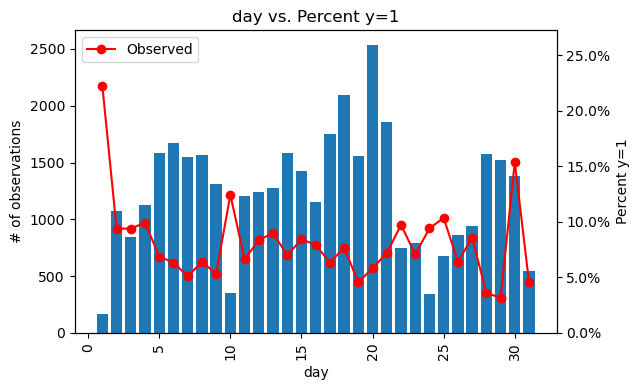

In [ ]:
fp.plot_feature_vs_y(df,feature = 'day', y_col='y', dtype= 'cat', levels = list(range(1,32)), show_boxplot=False)

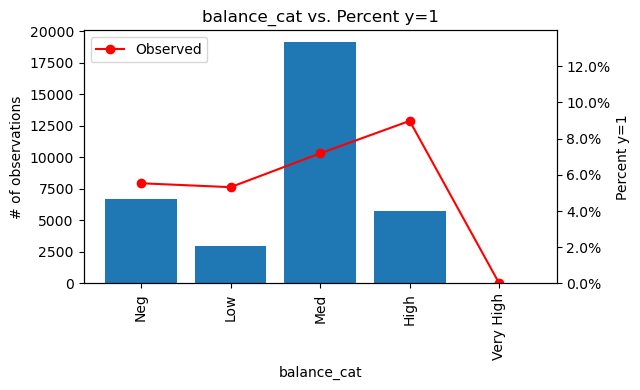

In [ ]:
fp.plot_feature_vs_y(df, feature = 'balance_cat',y_col='y', dtype= 'cat', levels = ['Neg', 'Low', 'Med', 'High', 'Very High'], show_boxplot=False)

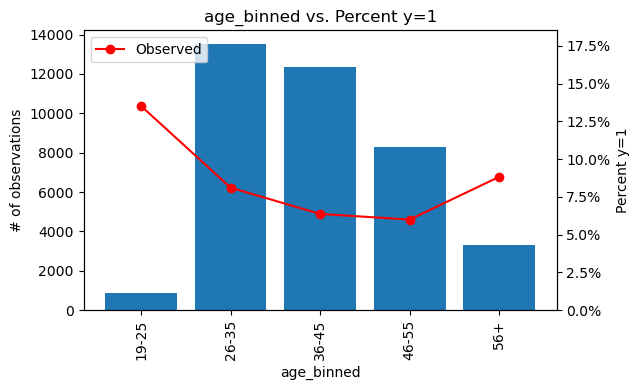

In [ ]:
fp.plot_feature_vs_y(df, feature = 'age_binned',y_col='y', dtype= 'cat', levels = [ "19-25", "26-35", "36-45", "46-55", "56+"], show_boxplot=False)

/var/folders/4l/s81p4w090kx1p7r6kb_bznjm0000gn/T/ipykernel_9592/2590238381.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["age_binned_combined"] = df["age_binned"].replace({


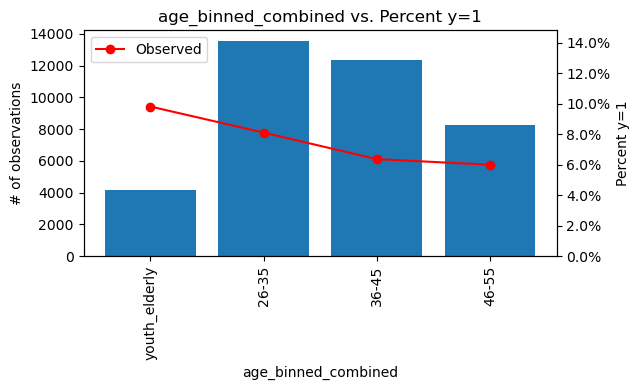

In [ ]:
df["age_binned_combined"] = df["age_binned"].replace({
    "19-25": "youth_elderly",
    "56+": "youth_elderly"
})
fp.plot_feature_vs_y(df, feature = 'age_binned_combined',y_col='y', dtype= 'cat', levels = [ "youth_elderly", "26-35", "36-45", "46-55"], show_boxplot=False)

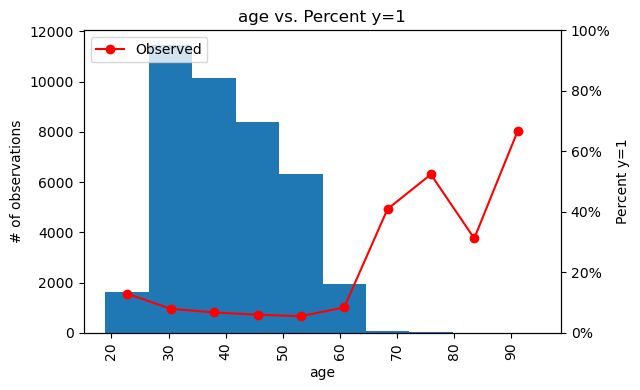

In [ ]:
fp.plot_feature_vs_y(df, feature = 'age',y_col='y', dtype= 'quant', show_boxplot=False, n_bins= 10, bin_method="cut")

In [ ]:
#Check to ensure the values make sense
#Remove outliers by variable instead of general sweep
#Only remove outliers in training data

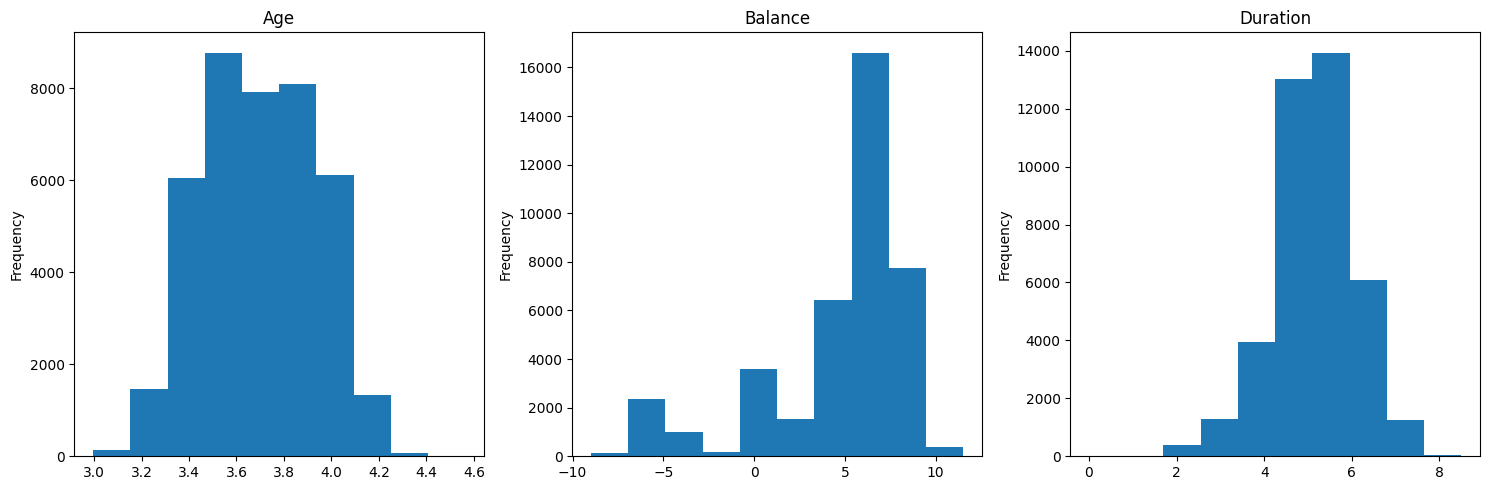

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age_log.plot.hist(ax=axes[0], title="Age")
df.balance_log.plot.hist(ax=axes[1], title="Balance")
df.duration_log.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

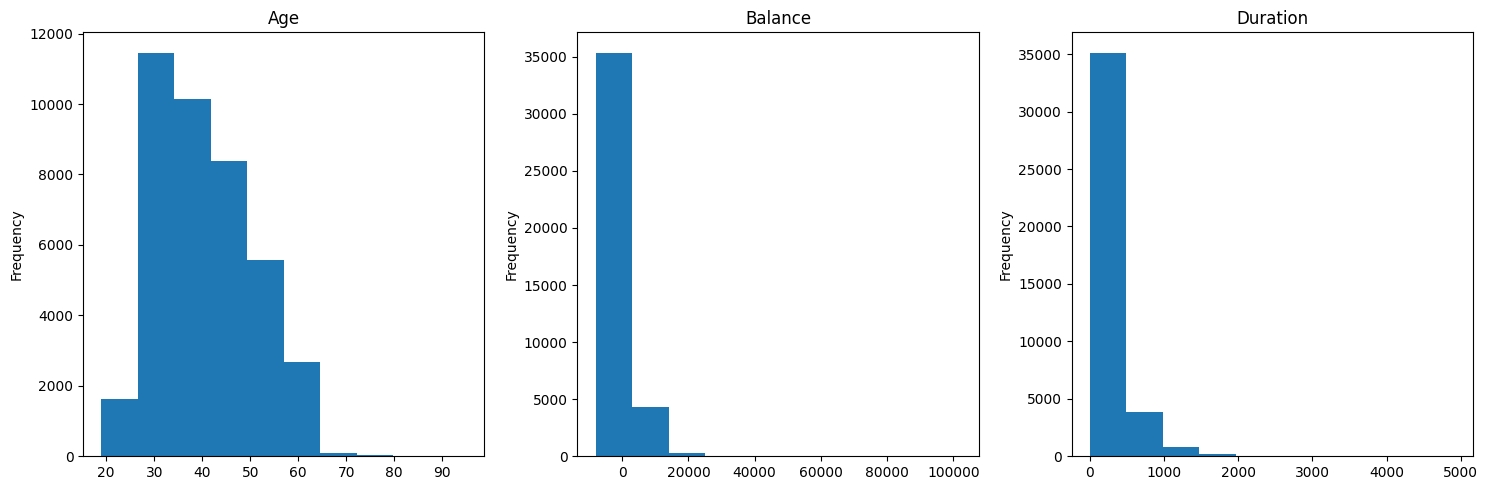

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age.plot.hist(ax=axes[0], title="Age")
df.balance.plot.hist(ax=axes[1], title="Balance")
df.duration.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

In [ ]:
# Make a grid of 2 rows × 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

df.job.value_counts().plot.barh(ax=axes[0], title="Job")
df.marital.value_counts().plot.barh(ax=axes[1], title="Marital")
df.education.value_counts().plot.barh(ax=axes[2], title="Education")
df.contact.value_counts().plot.barh(ax=axes[3], title="Contact")
df.month.value_counts().plot.barh(ax=axes[4], title="Month")

# Hide the unused subplot (6th slot)
axes[5].axis("off")

plt.tight_layout()
plt.show()

###Explore Variable relationships with Y

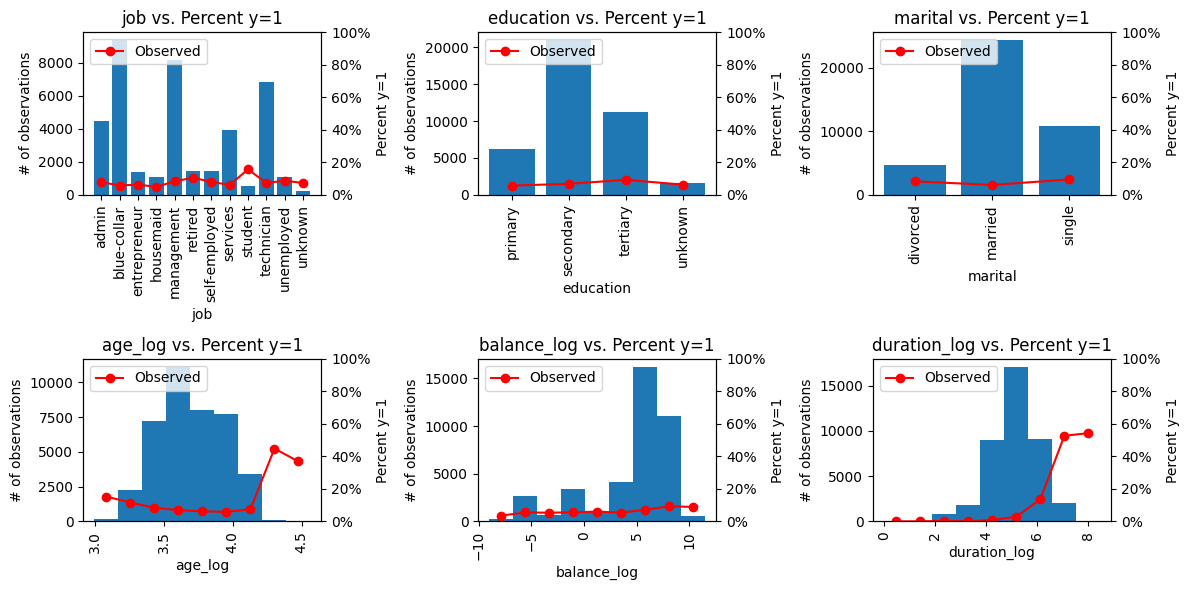

In [ ]:
# Grid of many features
fp.plot_features_vs_y_grid(
    df, ["job","education","marital","age_log","balance_log","duration_log"],
    y_col="y",
    dtype={"job":"cat","education":"cat","marital":"cat","age_log":"quant","balance_log":"quant","duration_log":"quant"},
    n_bins=9, cols=3, bin_method = "cut"
)


##Model

**Data_split**

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y',
       'payday', 'age_log'],
      dtype='object')

In [4]:
y = df["y"]
# X = df.drop(columns=["y", "age_log", "balance", "duration_log","job","age_binned"])
X = df.drop(columns=["y","age"])
X.sample(15)


NameError: name 'df' is not defined

In [ ]:
#Preprocessing Data
# cat = ["job_combined","education","marital","contact","balance_cat"]
cat = ["job", "education","marital","contact"]
#OneHot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(
    [('one_hot', OneHotEncoder(dtype='float'), cat)],
    remainder='passthrough', verbose_feature_names_out=False)

X_hot_encode = ct.fit_transform(X)
hot_encode_names = ct.get_feature_names_out().tolist()
hot_encode_names

['job_admin',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'month',
 'duration',
 'campaign',
 'age_log',
 'payday']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_hot_encode, y, test_size=0.20, random_state=42)


In [ ]:
# Recombine training data
train = pd.DataFrame(X_train, columns=hot_encode_names)
train['y'] = y_train.values
train
# Separate majority and minority classes
majority = train[train.y == 0]
minority = train[train.y == 1]

# Upsample minority to match majority size
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Combine back together
train_upsampled = pd.concat([majority, minority_upsampled])

# Split X and y again
X_train_balanced = train_upsampled.drop("y", axis=1)
y_train_balanced = train_upsampled["y"]

print("Before upsampling:\n", y_train.value_counts())
print("\nAfter upsampling:\n", y_train_balanced.value_counts())

Before upsampling:
 y
0    29680
1     2320
Name: count, dtype: int64

After upsampling:
 y
0    29680
1    29680
Name: count, dtype: int64


In [ ]:
X_train_balanced.columns

Index(['job_combined_admin', 'job_combined_blue-collar',
       'job_combined_entrepreneur', 'job_combined_housemaid',
       'job_combined_management', 'job_combined_self-employed',
       'job_combined_services', 'job_combined_student_retired',
       'job_combined_technician', 'job_combined_unemployed',
       'education_primary', 'education_secondary', 'education_tertiary',
       'marital_divorced', 'marital_married', 'marital_single',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'balance_cat_High', 'balance_cat_Low', 'balance_cat_Med',
       'balance_cat_Neg', 'balance_cat_Very_High', 'age', 'default', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'payday'],
      dtype='object')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best threshold: 0.73


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


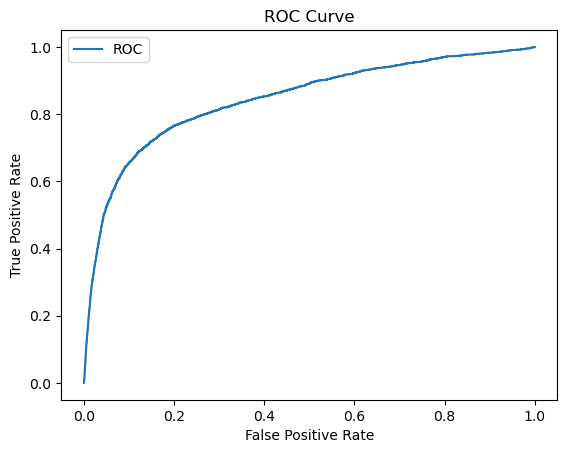

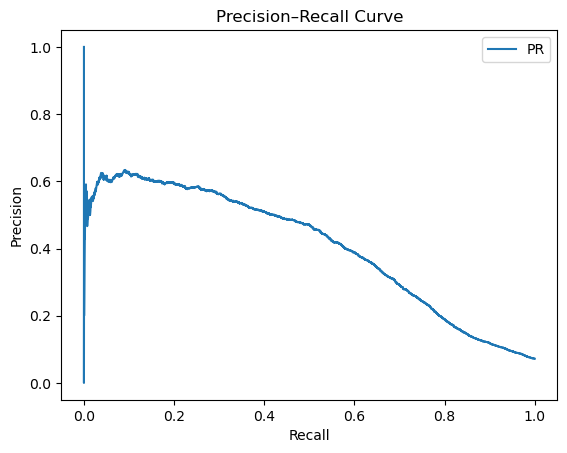

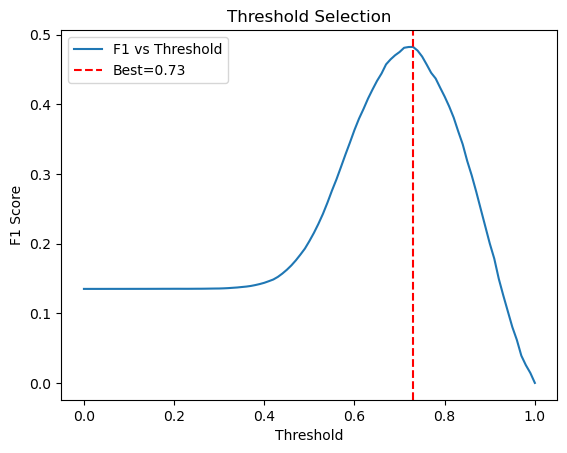

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=1,
    l1_ratio=0.5,
    max_iter=1000,
    class_weight="balanced"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0, 1, 101)
f1_scores = np.zeros_like(thresholds, dtype=float)

X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)

for train_idx, val_idx in cv.split(X_hot_encode, y):
    lr.fit(X_hot_encode.iloc[train_idx], y.iloc[train_idx])
    probs = lr.predict_proba(X_hot_encode.iloc[val_idx])[:, 1]
    for i, t in enumerate(thresholds):
        preds = (probs >= t).astype(int)
        f1_scores[i] += f1_score(y.iloc[val_idx], preds)

f1_scores /= cv.get_n_splits()

best_t = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_t)

# Fit once on full training set
lr.fit(X_hot_encode, y)
probs = lr.predict_proba(X_hot_encode)[:, 1]

fpr, tpr, roc_thres = roc_curve(y, probs)
precision, recall, pr_thres = precision_recall_curve(y, probs)

plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.figure()
plt.plot(recall, precision, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()

plt.figure()
plt.plot(thresholds, f1_scores, label="F1 vs Threshold")
plt.axvline(best_t, color="r", linestyle="--", label=f"Best={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Selection")
plt.legend()
plt.show()


In [ ]:
# Linear Regresssion - original
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
lr = LogisticRegression(penalty='elasticnet', solver= 'saga', C=1, l1_ratio=0.5, max_iter=5000,class_weight="balanced")
lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,5000
,multi_class,'deprecated'


In [ ]:
y_prob_test = lr.predict_proba(X_test)[:, 1]
y_prob_train = lr.predict_proba(X_train)[:, 1]
threshold = 0.73
y_pred_test = (y_prob_test >= threshold).astype(int)
y_pred_train = (y_prob_train >= threshold).astype(int)
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

Train Metrics
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29680
           1       0.43      0.52      0.47      2320

    accuracy                           0.91     32000
   macro avg       0.70      0.73      0.71     32000
weighted avg       0.92      0.91      0.92     32000

Test Metrics
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7424
           1       0.42      0.54      0.47       576

    accuracy                           0.91      8000
   macro avg       0.69      0.74      0.71      8000
weighted avg       0.92      0.91      0.92      8000



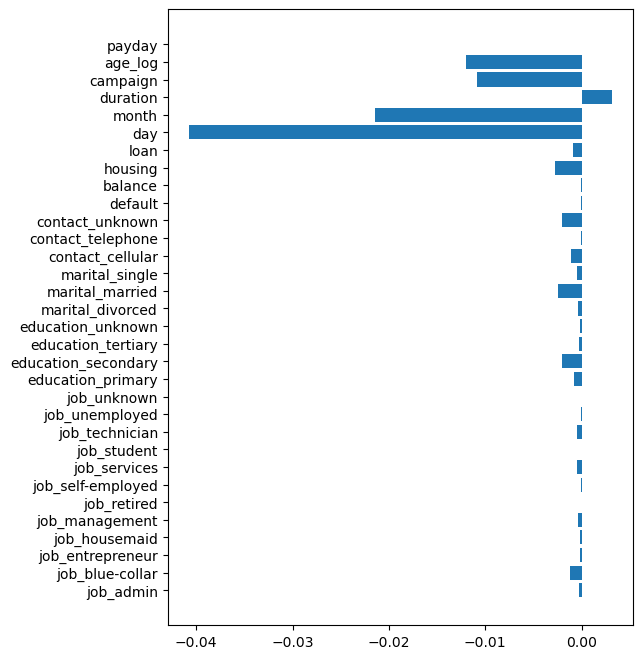

In [ ]:
plt.figure(figsize=(6, 8))
plt.barh(hot_encode_names, lr.coef_[0])
plt.show()

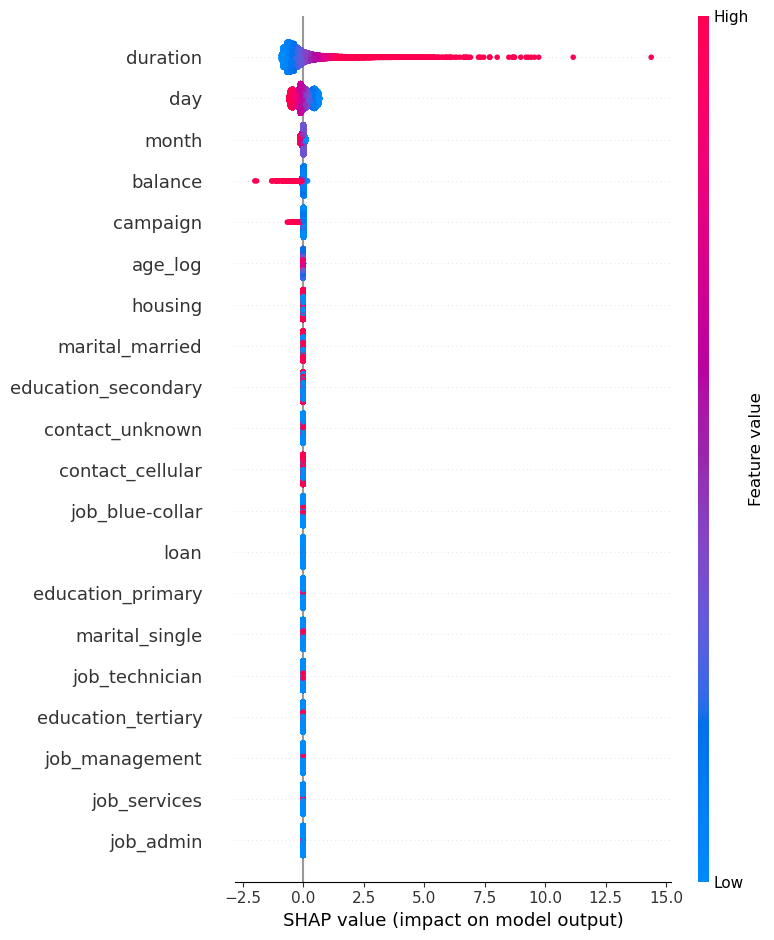

In [ ]:
import shap

# Assumes X_hot_encode is a DataFrame
explainer = shap.LinearExplainer(lr, X_hot_encode, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_hot_encode)

shap.summary_plot(shap_values, X_hot_encode)



In [ ]:
# Stratified sampling: equal from each class
n_per_class = 100
idx_0 = y[y == 0].sample(n=n_per_class, random_state=42).index
idx_1 = y[y == 1].sample(n=n_per_class, random_state=42).index

X_sample = X_hot_encode.loc[idx_0.union(idx_1)]
y_sample = y.loc[idx_0.union(idx_1)]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, shap.sample(X_hot_encode, 100))
shap_values = explainer.shap_values(X_sample)
explanation = explainer(X_sample)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
shap.plots.beeswarm(explanation)

#Try different models as well

In [ ]:
from numpy import mean
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier
import numpy as np

# define model
model = XGBClassifier(
    objective='binary:logistic',
    max_delta_step=1,
    eval_metric="logloss"   # prevents XGBoost warning
)

# define parameter distributions\
#add n_estimator into grid search
param_dist = {
    "scale_pos_weight": [1, 12.6, 25, 50, 75, 99, 100, 1000],
    "gamma": np.linspace(0, 5, 20),                 # values between 0 and 5
    "learning_rate": np.linspace(0.01, 0.3, 30)     # values between 0.01 and 0.3
    "n_estimators":[1000, 500, 5000]
}

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define random search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,              # number of random samples to try
    scoring="f1",
    n_jobs=-1,
    cv=cv,
    random_state=1,
    verbose=1
)

# execute the search
random_result = random_search.fit(X_hot_encode, y)

# report the best configuration
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

# report all configs
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


#0.951647

Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Best: 0.538356 using {'scale_pos_weight': 12.6, 'learning_rate': 0.25999999999999995, 'gamma': 1.3157894736842104}
0.484809 (0.027895) with: {'scale_pos_weight': 1, 'learning_rate': 0.21999999999999997, 'gamma': 3.9473684210526314}
0.442911 (0.008980) with: {'scale_pos_weight': 50, 'learning_rate': 0.10999999999999997, 'gamma': 4.7368421052631575}
0.356615 (0.004868) with: {'scale_pos_weight': 99, 'learning_rate': 0.039999999999999994, 'gamma': 2.1052631578947367}
0.402403 (0.007520) with: {'scale_pos_weight': 99, 'learning_rate': 0.10999999999999997, 'gamma': 1.0526315789473684}
0.446318 (0.007705) with: {'scale_pos_weight': 50, 'learning_rate': 0.12999999999999998, 'gamma': 5.0}
0.433782 (0.007705) with: {'scale_pos_weight': 99, 'learning_rate': 0.3, 'gamma': 4.7368421052631575}
0.437082 (0.009309) with: {'scale_pos_weight': 50, 'learning_rate': 0.09999999999999998, 'gamma': 0.7894736842105263}
0.432067 (0.009376) with: 

In [ ]:
# create model instance
#n_estimators=1000, max_depth=5, learning_rate=.1, objective='binary:logistic',
# model = XGBClassifier(learning_rate= 0.26, objective='binary:logistic',gamma = 1.31579,max_delta_step=1, scale_pos_weight=12.6)

#number_estimates
#Random Forest
model = XGBClassifier(learning_rate= 0.26, objective='binary:logistic',gamma = 1.31579,max_delta_step=1)
# fit model
# model.fit(X_train, y_train)
model.fit(X_train_balanced, y_train_balanced)
# make predictions
threshold = 0.7
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= threshold).astype(int)
y_pred_train = (y_prob_train >= threshold).astype(int)

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = bst.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_preds_test
#Work more towards experimenting models and parameter searching

array([[0.8341824 , 0.16581762],
       [0.9955687 , 0.00443131],
       [0.99603367, 0.00396634],
       ...,
       [0.9866044 , 0.01339562],
       [0.99797946, 0.00202053],
       [0.9976703 , 0.00232972]], dtype=float32)

In [ ]:
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

Train Metrics
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     29680
           1       0.57      0.93      0.71      2320

    accuracy                           0.94     32000
   macro avg       0.78      0.94      0.84     32000
weighted avg       0.96      0.94      0.95     32000

Test Metrics
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7424
           1       0.47      0.75      0.58       576

    accuracy                           0.92      8000
   macro avg       0.73      0.84      0.77      8000
weighted avg       0.94      0.92      0.93      8000



In [ ]:
model.classes_

array([0, 1])

In [ ]:
print("Train")
cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
disp.plot()
print("Test")
cm_test = confusion_matrix(y_test, y_preds_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp_test.plot()
plt.show()

Train


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

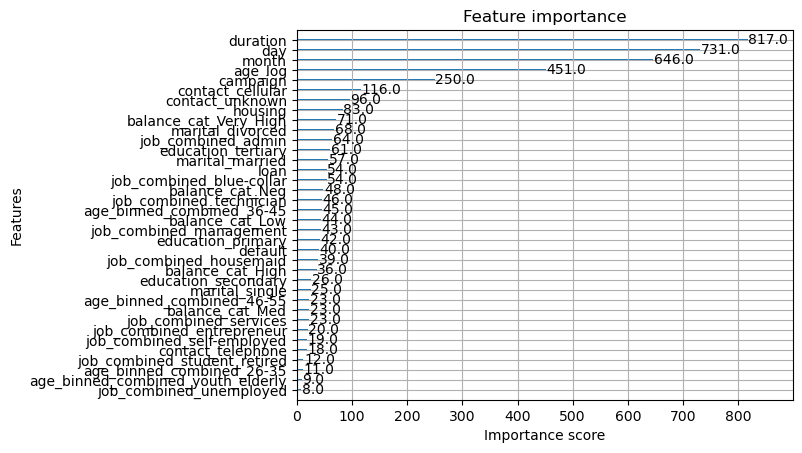

In [ ]:
#AUC/ROC
#Predicted vs. Observed
model.get_booster().feature_names = hot_encode_names
plot_importance(model.get_booster())
plt.show()

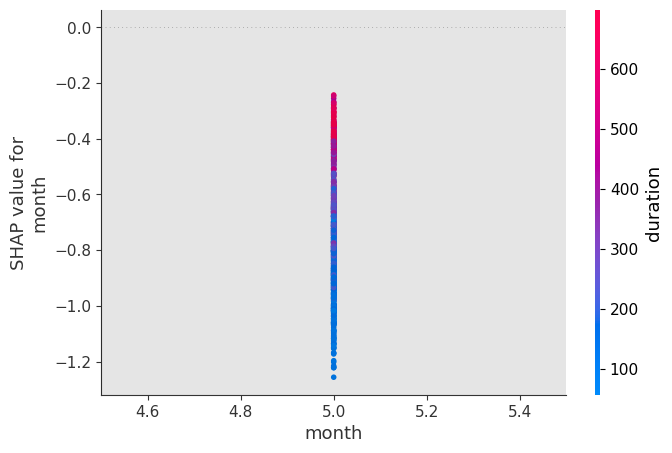

In [ ]:
import shap
X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)
explainer = shap.Explainer(model)
shap_values = explainer(X_hot_encode)
shap.initjs()
explanation = explainer(X_hot_encode[:1000])
shap.plots.scatter(explanation[:, "month"], color=explanation)


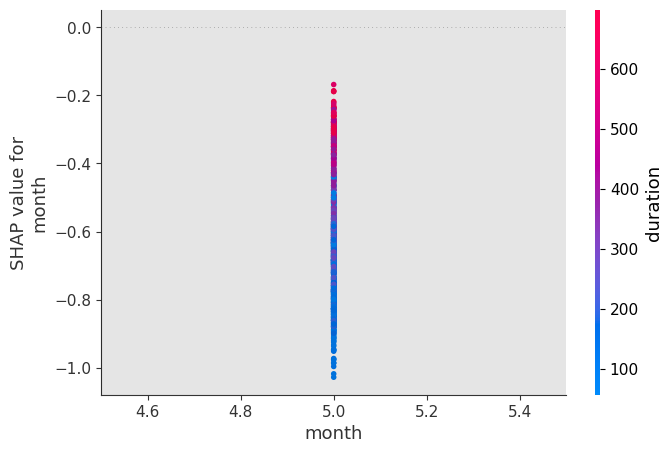

In [ ]:
X_hot_encode.month.value_counts()

month
5.0     12974
7.0      6128
8.0      5070
6.0      4405
11.0     3492
4.0      2621
2.0      2205
1.0      1110
3.0       243
10.0       77
12.0       13
Name: count, dtype: int64

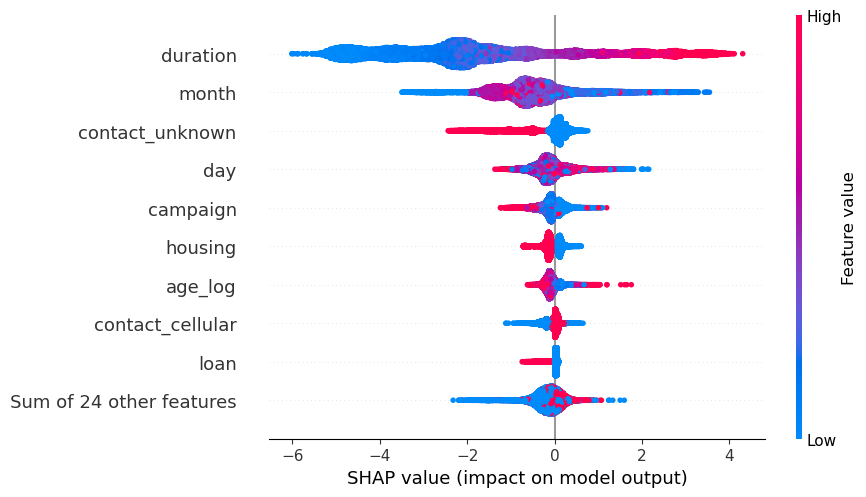

In [ ]:
import matplotlib.pyplot as plt

shap.plots.beeswarm(shap_values)
# plt.savefig("YyqSMCLaRZesyT0w/waterfall_plot.png", bbox_inches="tight", dpi=300)
# plt.close()  # optional, so figures don’t pile up in memory


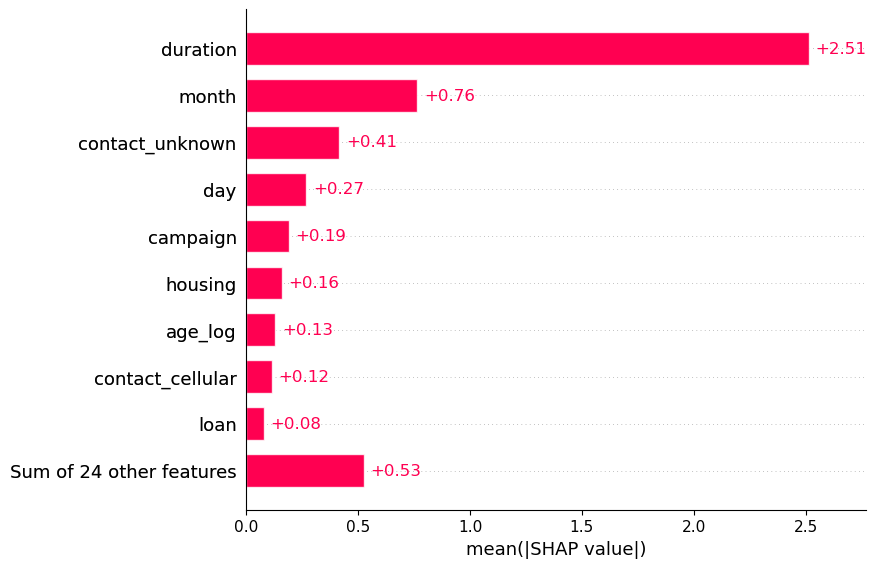

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

In [ ]:
n_bins = 8
AVG_bin = pd.qcut(df['AVG'], q=n_bins, duplicates='drop')

agg = (df
       .groupby(AVG_bin, observed=True)
       .agg(count=('y','size'), prop_y1=('y','mean'),
            x_mid=('AVG', 'median'))
       .reset_index())

# Plot
fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(10,4), gridspec_kw={'width_ratios':[2,1]})

# Left plot: counts + proportion
ax_left.bar(agg['x_mid'], agg['count'],
            width=np.diff(np.r_[agg['x_mid'], agg['x_mid'].iloc[-1]]).mean())
ax_left.set_xlabel('AVG (binned, midpoint)')
ax_left.set_ylabel('# of observations')

ax2 = ax_left.twinx()
ax2.plot(agg['x_mid'], agg['prop_y1'], marker='o', color='red')
ax2.set_ylabel('P(Y=1)')
ax2.set_ylim(0,1)
ax_left.set_title('P(Y=1) vs AVG (binned)')

# Right plot: boxplot
sns.boxplot(x='Y', y='AVG', data=df, ax=ax_right)
ax_right.set_title('Distribution of AVG by Y')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_feature_vs_happiness(df,feature,y_col="y", y_pred_col=None,
                              levels=(1, 2, 3, 4, 5),
                              show_boxplot=True,figsize=(10, 4)):
    from matplotlib.ticker import PercentFormatter
    # counts and means (fill missing categories with 0)
    counts = df[feature].value_counts().reindex(levels, fill_value=0)
    obs = df.groupby(feature)[y_col].mean().reindex(levels, fill_value=0.0)

    pred = None
    if y_pred_col and y_pred_col in df.columns:
        pred = df.groupby(feature)[y_pred_col].mean().reindex(levels, fill_value=0.0)

    # figure / axes
    if show_boxplot:
        fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=figsize)
    else:
        fig, ax_left = plt.subplots(figsize=(figsize[0]*0.65, figsize[1]))
        ax_right = None

    # LEFT: bars + one twin axis for both lines
    ax_left.bar(counts.index, counts.values)
    ax_left.set_xlabel(feature)
    ax_left.set_ylabel('# of observations')
    ax_left.set_title(f'{feature} vs. customer satisfaction')

    ax_line = ax_left.twinx()
    ax_line.set_ylabel('Percent Happy')
    ax_line.set_ylim(0, 1)
    ax_line.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    # plot observed (+ optional predicted) with a tiny loop
    handles = []
    for series, label, color in [(obs, 'Observed', 'red'), (pred, 'Predicted', 'yellow')]:
        if series is None:
            continue
        (ln,) = ax_line.plot(series.index, series.values, marker='o', label=label, color=color)
        handles.append(ln)

    if handles:
        ax_line.legend(handles=handles, loc='upper left')

    # RIGHT: optional boxplot
    if show_boxplot:
        sns.boxplot(x=y_col, y=feature, data=df, ax=ax_right)
        ax_right.set_title(f'Distribution of {feature} by {y_col}')
        ax_right.set_xlabel(f'{y_col} (0: Unhappy, 1: Happy)')

    plt.tight_layout()
    return fig, (ax_left, ax_right)
